<a href="https://colab.research.google.com/github/m-majchrzak/Optimization_Adaquant/blob/main/main_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Libraries & Setup

In [1]:
# %cd /content/
# !rm -r ./Optimization_Adaquant/
# !git clone https://github.com/m-majchrzak/Optimization_Adaquant.git
# %cd Optimization_Adaquant/
# !pip install pyunpack
# from pyunpack import Archive
# Archive('calibration_datasets.zip').extractall("")

/content
rm: cannot remove './Optimization_Adaquant/': No such file or directory
Cloning into 'Optimization_Adaquant'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 128 (delta 62), reused 70 (delta 25), pack-reused 0
Receiving objects: 100% (128/128), 6.31 MiB | 20.72 MiB/s, done.
Resolving deltas: 100% (62/62), done.
/content/Optimization_Adaquant
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import random
from functools import partial

import numpy as np
import pandas as pd
import torch.backends.cudnn as cudnn
import torch.nn.parallel

from sklearn.metrics import accuracy_score
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam

from utils.adaquant import optimize_layer_adaquant
from utils.load_dataset import load_dataset
from utils.misc import set_global_seeds
from utils.mobilenet_v2 import mobilenet_v2, MobileNetV2
from utils.quantize import QConv2d, QLinear
from utils.resnet import ResNet_imagenet
from utils.trainer import Trainer

import cv2
import matplotlib.pyplot as plt
from utils.kaggle_cifar_10_dataset import KaggleCIFAR10Dataset
import torchvision.transforms as transforms



In [2]:
acc = -1
loss = -1
best_prec1 = 0
dtype = torch.float32

### SET SEED
seed = 123
set_global_seeds(seed)

device_ids = list(range(torch.cuda.device_count()))
if torch.cuda.is_available():
    torch.cuda.set_device(device_ids[0])
    cudnn.benchmark = True
else:
    device_ids = None

## Data

In [46]:
# # Calib data loading code
# calib_directory = "./data/calibration"
# calib_batch_size = 100
# calib_data = load_dataset(calib_directory, calib_batch_size)

In [29]:
# # Train data loading code
# train_directory = "./data/train"
# train_batch_size = 100
# train_data = load_dataset(train_directory, train_batch_size)

In [49]:
# def predict_from_dataloader(dataloader, model):
#     # model.eval()
#     # model.to(device)
#     with torch.no_grad():
#         for i, (inputs, labels) in enumerate(dataloader):
#             # inputs, labels = data
#             # inputs = inputs.to(device)
#             # labels = labels.to(device)
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             if i == 0:
#                 all_predicted = predicted
#                 all_labels = labels
#             else:
#                 all_predicted = torch.cat((all_predicted, predicted), 0)
#                 all_labels = torch.cat((all_labels, labels), 0)
#     return all_predicted, all_labels

In [54]:
def val_loop(dataloader, model, device):
    size = len(dataloader.dataset)
    n_batches = len(dataloader)
    val_loss, score = 0, 0

    with torch.no_grad():
        for batch_imgs, batch_labels in dataloader:
            batch_imgs, batch_labels = batch_imgs.to(device), batch_labels.to(device)
            logits = model(batch_imgs)
            # val_loss += loss_fn(logits, batch_labels).item()
            score += (logits.argmax(1) == batch_labels).type(torch.float).sum().item()

    # val_loss /= n_batches
    score /= size
    accuracy = 100 * score
    # print(f'Validation error: \n Accuracy: {(accuracy):>0.1f}, Avg loss: {val_loss:>8f}\n')
    return accuracy

In [30]:
def set_seeds(seed):
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [31]:
set_seeds(0)

In [78]:
dataset = KaggleCIFAR10Dataset(
        'data/calibration_Wladek', 
        'data/calibration_labels.csv', 
         transforms.Compose([ # basic augmentation
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(),
                transforms.RandomRotation(10)
            ]))

cal_dataloader, _ = dataset.get_train_val_dataloaders(
    0.999, 
    {
        'batch_size': 128,
        'shuffle': False,
    })

In [60]:
dataset = KaggleCIFAR10Dataset(
        'cifar-10/train', 
        'cifar-10/trainLabels.csv', 
         transforms.Compose([ # basic augmentation
                transforms.RandomHorizontalFlip(),
                transforms.ColorJitter(),
                transforms.RandomRotation(10)
            ]))

train_dataloader, val_dataloader = dataset.get_train_val_dataloaders(
    0.9, 
    {
        'batch_size': 128,
        'shuffle': True,
    })

In [58]:
model = MobileNetV2(num_bits=8, num_bits_weight=8)
model.load_state_dict(torch.load('./mobilenet1.pt'))

<All keys matched successfully>

In [59]:
val_loop(cal_dataloader, model, 'cpu')

7.707707707707708

In [ ]:
val_loop(val_dataloader, model, 'cpu')

tensor(4)
tensor(9)
tensor(8)
tensor(3)
tensor(5)
tensor(3)
tensor(3)
tensor(6)


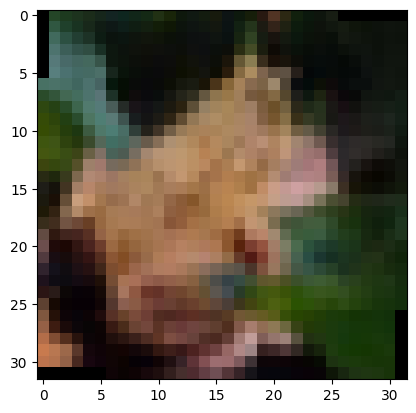

In [79]:
for img, labels in cal_dataloader:
    plt.imshow(img[0].permute(1,2,0))
    print(labels[0])

In [70]:
dataset.get_labels_mapping()

{'frog': 0,
 'truck': 1,
 'deer': 2,
 'automobile': 3,
 'bird': 4,
 'horse': 5,
 'ship': 6,
 'cat': 7,
 'dog': 8,
 'airplane': 9}

In [61]:
val_loop(val_dataloader, model, 'cpu')

45.00900180036007

## Model, Optimizer, Trainer

In [5]:
### CREATE MODEL
# model = ResNet_imagenet()
# model = mobilenet_v2()  # num_bits=32, num_bits_weight=32)

# # define loss function (criterion)
# criterion = CrossEntropyLoss()

# # optimizer configuration
# optimizer = SGD(model.parameters(), lr=1e-2, momentum=0.5, weight_decay=0)

# TRAINER
# trainer = Trainer(model, criterion, optimizer, device=torch.device('cuda'))
# trainer = Trainer(model, criterion, optimizer, device=torch.device("cpu"))

Using cache found in C:\Users\wlady/.cache\torch\hub\chenyaofo_pytorch-cifar-models_master


In [39]:
### LOAD MODEL
# model = MobileNetV2(num_bits=32, num_bits_weight=32)
# model.load_state_dict(torch.load('./mobilenet1.pt'))
criterion = CrossEntropyLoss()

# optimizer configuration
optimizer = SGD(model.parameters(), lr=1e-2, momentum=0.5, weight_decay=0)
trainer = Trainer(model, criterion, optimizer, device=torch.device("cpu"))

## Cache, Hook

In [40]:
cached_qinput = {}


def Qhook(name, module, input, output):
    if module not in cached_qinput:
        cached_qinput[module] = []
        # Meanwhile store data in the RAM.
        cached_qinput[module].append(input[0].detach().cpu())
        # print(name)

In [41]:
cached_input_output = {}


def hook(name, module, input, output):
    if module not in cached_input_output:
        cached_input_output[module] = []
    # Meanwhile store data in the RAM.
    cached_input_output[module].append((input[0].detach().cpu(), output.detach().cpu()))
    # print(name)

In [42]:
for name, m in model.named_modules():
    if isinstance(m, QConv2d) or isinstance(m, QLinear):
        print(name)
        m.name = name

features.0.0
features.1.conv.0.0
features.1.conv.1
features.2.conv.0.0
features.2.conv.1.0
features.2.conv.2
features.3.conv.0.0
features.3.conv.1.0
features.3.conv.2
features.4.conv.0.0
features.4.conv.1.0
features.4.conv.2
features.5.conv.0.0
features.5.conv.1.0
features.5.conv.2
features.6.conv.0.0
features.6.conv.1.0
features.6.conv.2
features.7.conv.0.0
features.7.conv.1.0
features.7.conv.2
features.8.conv.0.0
features.8.conv.1.0
features.8.conv.2
features.9.conv.0.0
features.9.conv.1.0
features.9.conv.2
features.10.conv.0.0
features.10.conv.1.0
features.10.conv.2
features.11.conv.0.0
features.11.conv.1.0
features.11.conv.2
features.12.conv.0.0
features.12.conv.1.0
features.12.conv.2
features.13.conv.0.0
features.13.conv.1.0
features.13.conv.2
features.14.conv.0.0
features.14.conv.1.0
features.14.conv.2
features.15.conv.0.0
features.15.conv.1.0
features.15.conv.2
features.16.conv.0.0
features.16.conv.1.0
features.16.conv.2
features.17.conv.0.0
features.17.conv.1.0
features.17.conv

In [43]:
handlers = []
count = 0
for name, m in model.named_modules():
    if isinstance(m, QConv2d) or isinstance(m, QLinear):
        # if isinstance(m, Conv2d) or isinstance(m, Linear):
        # if isinstance(m, QConv2d):
        m.quantize = False
        # if count < 10:
        # if (isinstance(m, QConv2d) and m.groups == 1) or isinstance(m, QLinear):
        handlers.append(m.register_forward_hook(partial(hook, name)))
        count += 1

In [48]:
# Store input/output for all quantizable layers
trainer.validate(val_dataloader)
print("Input/outputs cached")

Input/outputs cached


In [49]:
for handler in handlers:
    handler.remove()

In [50]:
for m in model.modules():
    if isinstance(m, QConv2d) or isinstance(m, QLinear):
        m.quantize = True

In [51]:
print(cached_input_output.keys())

dict_keys([QConv2d(
  3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False
  (quantize_input): QuantThUpdate()
  (quantize_weight): QuantThUpdate()
), QConv2d(
  32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False
  (quantize_input): QuantThUpdate()
  (quantize_weight): QuantThUpdate()
), QConv2d(
  32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
  (quantize_input): QuantThUpdate()
  (quantize_weight): QuantThUpdate()
), QConv2d(
  16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False
  (quantize_input): QuantThUpdate()
  (quantize_weight): QuantThUpdate()
), QConv2d(
  96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=96, bias=False
  (quantize_input): QuantThUpdate()
  (quantize_weight): QuantThUpdate()
), QConv2d(
  96, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
  (quantize_input): QuantThUpdate()
  (quantize_weight): QuantThUpdate()
), QConv2d(
  24, 144, kernel_size=(1, 1), stride=(1, 1), bias=False
  (quant

## Loop Through Layers

In [52]:
mse_df = pd.DataFrame(
    index=np.arange(len(cached_input_output)),
    columns=["name", "bit", "shape", "mse_before", "mse_after", "acc"],
)
print_freq = 100
evaluate = "evaluate"

In [53]:
for i, layer in enumerate(cached_input_output):
    if i > 0:  # and seq_adaquant = True
        count = 0
        cached_qinput = {}
        for name, m in model.named_modules():
            if layer.name == name:
                if count < 5:
                    handler = m.register_forward_hook(partial(Qhook, name))
                    count += 1
        # Store input/output for all quantizable layers
        trainer.validate(calib_data)
        print("cashed quant Input%s" % layer.name)
        cached_input_output[layer][0] = (
            cached_qinput[layer][0],
            cached_input_output[layer][0][1],
        )
        handler.remove()
    print(
        "\nOptimize {}:{} for {} bit of shape {}".format(
            i, layer.name, layer.num_bits, layer.weight.shape
        )
    )

    mse_before, mse_after = optimize_layer_adaquant(layer, cached_input_output[layer])
    acc=val_loop(val_dataloader, model, 'cpu')

    print("\nMSE before optimization: {}".format(mse_before))
    print("MSE after optimization:  {}".format(mse_after))
    mse_df.loc[i, "name"] = layer.name
    mse_df.loc[i, "bit"] = layer.num_bits
    mse_df.loc[i, "shape"] = str(layer.weight.shape)
    mse_df.loc[i, "mse_before"] = mse_before
    mse_df.loc[i, "mse_after"] = mse_after
    mse_df.loc[i, "acc"] = acc


mse_csv = evaluate + ".mse.csv"
mse_df.to_csv(mse_csv)

filename = evaluate + "_adaquant_val02"
torch.save(model.state_dict(), filename)

calib_data = None
cached_input_output = None
# val_results = trainer.validate(val_data.get_loader())
# logging.info(val_results)


Optimize 0:features.0.0 for 8 bit of shape torch.Size([32, 3, 3, 3])


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 84.58it/s]



MSE before optimization: 0.2649571895599365
MSE after optimization:  0.029226889833807945
cashed quant Inputfeatures.1.conv.0.0

Optimize 1:features.1.conv.0.0 for 8 bit of shape torch.Size([32, 1, 3, 3])


100%|██████████| 100/100 [00:02<00:00, 45.53it/s]



MSE before optimization: 0.002470217877998948
MSE after optimization:  0.0009993225103244185
cashed quant Inputfeatures.1.conv.1

Optimize 2:features.1.conv.1 for 8 bit of shape torch.Size([16, 32, 1, 1])


100%|██████████| 100/100 [00:01<00:00, 55.05it/s]



MSE before optimization: 0.0028403126634657383
MSE after optimization:  0.0027618911117315292
cashed quant Inputfeatures.2.conv.0.0

Optimize 3:features.2.conv.0.0 for 8 bit of shape torch.Size([96, 16, 1, 1])


100%|██████████| 100/100 [00:01<00:00, 53.43it/s]



MSE before optimization: 0.05337725952267647
MSE after optimization:  0.05337467044591904
cashed quant Inputfeatures.2.conv.1.0

Optimize 4:features.2.conv.1.0 for 8 bit of shape torch.Size([96, 1, 3, 3])


100%|██████████| 100/100 [00:04<00:00, 23.71it/s]



MSE before optimization: 0.04495564475655556
MSE after optimization:  0.03622474893927574
cashed quant Inputfeatures.2.conv.2

Optimize 5:features.2.conv.2 for 8 bit of shape torch.Size([24, 96, 1, 1])


100%|██████████| 100/100 [00:01<00:00, 55.65it/s]



MSE before optimization: 0.08768093585968018
MSE after optimization:  0.08690611273050308
cashed quant Inputfeatures.3.conv.0.0

Optimize 6:features.3.conv.0.0 for 8 bit of shape torch.Size([144, 24, 1, 1])


100%|██████████| 100/100 [00:00<00:00, 100.65it/s]



MSE before optimization: 0.08365686237812042
MSE after optimization:  0.07724959403276443
cashed quant Inputfeatures.3.conv.1.0

Optimize 7:features.3.conv.1.0 for 8 bit of shape torch.Size([144, 1, 3, 3])


 45%|████▌     | 45/100 [00:01<00:01, 38.62it/s]


KeyboardInterrupt: 

In [48]:
filename = evaluate + "_adaquant.pth"
torch.save(model.state_dict(), filename)

# Mobilenet experiments

In [54]:
all_predicted, all_labels = predict_from_dataloader(calib_data, model)
acc = accuracy_score(all_labels.cpu().numpy(), all_predicted.cpu().numpy())

In [55]:
acc

0.1

In [13]:
model_xd = MobileNetV2()

In [14]:
all_predicted, all_labels = predict_from_dataloader(calib_data, model_xd)
acc_xd = accuracy_score(all_labels.cpu().numpy(), all_predicted.cpu().numpy())

In [15]:
acc_xd

0.071

In [16]:
model_xd.load_state_dict(model.state_dict(), strict=False)

_IncompatibleKeys(missing_keys=['features.0.0.equ_scale', 'features.0.0.quantize_input.running_zero_point', 'features.0.0.quantize_input.running_range', 'features.0.0.quantize_weight.running_zero_point', 'features.0.0.quantize_weight.running_range', 'features.1.conv.0.0.equ_scale', 'features.1.conv.0.0.quantize_input.running_zero_point', 'features.1.conv.0.0.quantize_input.running_range', 'features.1.conv.0.0.quantize_weight.running_zero_point', 'features.1.conv.0.0.quantize_weight.running_range', 'features.1.conv.1.equ_scale', 'features.1.conv.1.quantize_input.running_zero_point', 'features.1.conv.1.quantize_input.running_range', 'features.1.conv.1.quantize_weight.running_zero_point', 'features.1.conv.1.quantize_weight.running_range', 'features.2.conv.0.0.equ_scale', 'features.2.conv.0.0.quantize_input.running_zero_point', 'features.2.conv.0.0.quantize_input.running_range', 'features.2.conv.0.0.quantize_weight.running_zero_point', 'features.2.conv.0.0.quantize_weight.running_range', '

In [17]:
all_predicted, all_labels = predict_from_dataloader(calib_data, model_xd)
acc_xd_after = accuracy_score(all_labels.cpu().numpy(), all_predicted.cpu().numpy())

In [18]:
acc_xd_after

0.1

In [22]:
len(model.features)

19

In [23]:
len(model_xd.features)

19

In [34]:
i = 0
for name, m in model.named_modules():
    i += 1
    # print(name)
    if isinstance(m, QConv2d) or isinstance(m, QLinear):
        print(name)
        # m.name = name
        # # print(m.name)
print(i)

213


In [35]:
j = 0
for name, m in model_xd.named_modules():
    # print(name)
    j += 1
    if isinstance(m, QConv2d) or isinstance(m, QLinear):
        print(name)
    #     m.name = name
    #     # print(m.name)
print(j)

features.0.0
features.1.conv.0.0
features.1.conv.1
features.2.conv.0.0
features.2.conv.1.0
features.2.conv.2
features.3.conv.0.0
features.3.conv.1.0
features.3.conv.2
features.4.conv.0.0
features.4.conv.1.0
features.4.conv.2
features.5.conv.0.0
features.5.conv.1.0
features.5.conv.2
features.6.conv.0.0
features.6.conv.1.0
features.6.conv.2
features.7.conv.0.0
features.7.conv.1.0
features.7.conv.2
features.8.conv.0.0
features.8.conv.1.0
features.8.conv.2
features.9.conv.0.0
features.9.conv.1.0
features.9.conv.2
features.10.conv.0.0
features.10.conv.1.0
features.10.conv.2
features.11.conv.0.0
features.11.conv.1.0
features.11.conv.2
features.12.conv.0.0
features.12.conv.1.0
features.12.conv.2
features.13.conv.0.0
features.13.conv.1.0
features.13.conv.2
features.14.conv.0.0
features.14.conv.1.0
features.14.conv.2
features.15.conv.0.0
features.15.conv.1.0
features.15.conv.2
features.16.conv.0.0
features.16.conv.1.0
features.16.conv.2
features.17.conv.0.0
features.17.conv.1.0
features.17.conv

In [44]:
model.features[1].conv[0][0]

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)

In [46]:
model_xd.features[1].conv[0][0].quantize_input

QuantThUpdate()

In [58]:
for name, param in model.named_parameters():
    print(name, param.shape)

features.0.0.weight torch.Size([32, 3, 3, 3])
features.0.1.weight torch.Size([32])
features.0.1.bias torch.Size([32])
features.1.conv.0.0.weight torch.Size([32, 1, 3, 3])
features.1.conv.0.1.weight torch.Size([32])
features.1.conv.0.1.bias torch.Size([32])
features.1.conv.1.weight torch.Size([16, 32, 1, 1])
features.1.conv.2.weight torch.Size([16])
features.1.conv.2.bias torch.Size([16])
features.2.conv.0.0.weight torch.Size([96, 16, 1, 1])
features.2.conv.0.1.weight torch.Size([96])
features.2.conv.0.1.bias torch.Size([96])
features.2.conv.1.0.weight torch.Size([96, 1, 3, 3])
features.2.conv.1.1.weight torch.Size([96])
features.2.conv.1.1.bias torch.Size([96])
features.2.conv.2.weight torch.Size([24, 96, 1, 1])
features.2.conv.3.weight torch.Size([24])
features.2.conv.3.bias torch.Size([24])
features.3.conv.0.0.weight torch.Size([144, 24, 1, 1])
features.3.conv.0.1.weight torch.Size([144])
features.3.conv.0.1.bias torch.Size([144])
features.3.conv.1.0.weight torch.Size([144, 1, 3, 3])

In [57]:
for name, param in model_xd.named_parameters():
    print(name, param.shape)

features.0.0.weight torch.Size([32, 3, 3, 3])
features.0.0.equ_scale torch.Size([32, 1, 1, 1])
features.0.0.quantize_input.running_zero_point torch.Size([1, 1, 1, 1])
features.0.0.quantize_input.running_range torch.Size([1, 1, 1, 1])
features.0.0.quantize_weight.running_zero_point torch.Size([32, 1, 1, 1])
features.0.0.quantize_weight.running_range torch.Size([32, 1, 1, 1])
features.0.1.weight torch.Size([32])
features.0.1.bias torch.Size([32])
features.1.conv.0.0.weight torch.Size([32, 1, 3, 3])
features.1.conv.0.0.equ_scale torch.Size([32, 1, 1, 1])
features.1.conv.0.0.quantize_input.running_zero_point torch.Size([1, 1, 1, 1])
features.1.conv.0.0.quantize_input.running_range torch.Size([1, 1, 1, 1])
features.1.conv.0.0.quantize_weight.running_zero_point torch.Size([32, 1, 1, 1])
features.1.conv.0.0.quantize_weight.running_range torch.Size([32, 1, 1, 1])
features.1.conv.0.1.weight torch.Size([32])
features.1.conv.0.1.bias torch.Size([32])
features.1.conv.1.weight torch.Size([16, 32, 1

In [ ]:
model.conv1.name = "QConv2d"

In [ ]:
model.conv1.name

'QConv2d'

In [ ]:
for k, v in cached_input_output.items():
    print(k)

QConv2d(
  3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
  (quantize_input): QuantThUpdate()
  (quantize_weight): QuantThUpdate()
)
QConv2d(
  64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
  (quantize_input): QuantThUpdate()
  (quantize_weight): QuantThUpdate()
)
QConv2d(
  64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
  (quantize_input): QuantThUpdate()
  (quantize_weight): QuantThUpdate()
)
QConv2d(
  64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
  (quantize_input): QuantThUpdate()
  (quantize_weight): QuantThUpdate()
)
QConv2d(
  64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
  (quantize_input): QuantThUpdate()
  (quantize_weight): QuantThUpdate()
)
QConv2d(
  256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
  (quantize_input): QuantThUpdate()
  (quantize_weight): QuantThUpdate()
)
QConv2d(
  64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
  (quantize_input): QuantThUpdate()
  (quanti